In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from utils.dataset import get_train_test_data, get_data_masks

# Read the featuremaps clusters data
featuremaps_df = pd.read_pickle('../logs/feature_combinations_clusters')
# Compute the total time
featuremaps_df['time'] = featuremaps_df['map_time'] + featuremaps_df['features_extraction']
featuremaps_df = featuremaps_df.drop(columns=['map_time', 'features_extraction'])

# Filter for the desired approach
featuremaps_df = featuremaps_df[
    # (featuremaps_df['map_size']  == '10x10') &
    (featuremaps_df['mode'] == 'original')
]

featuremaps_df['approach'] = featuremaps_df.apply(
    lambda row: f'{row["approach"]}({row["map_size"]})_{row["mode"]}',
    axis=1
)

# Read the heatmaps data
heatmaps_df = pd.read_pickle('../logs/heatmaps_data')
# Get the tuples linking each approach to its best configuration
heatmaps_df['perplexity'] = heatmaps_df['dim_red_techs_params'].apply(lambda params: float(params[-1]['perplexity']))
best_configs_df = pd.read_csv('../logs/best_configs.csv')
best_config_combs = list(
        best_configs_df[['explainer', 'perplexity']].itertuples(index=False, name=None)
    )
# Filter the data for the best configurations
heatmaps_df = heatmaps_df[heatmaps_df[['explainer', 'perplexity']].apply(tuple, axis=1).isin(best_config_combs)]

# Drop the values with null silhouette score
heatmaps_df = heatmaps_df.dropna(subset=['silhouette']).reset_index(drop=True)
# Keep the column of interest
heatmaps_df = heatmaps_df[['clustering_mode', 'explainer', 'clustering_technique', 'clusters', 'contributions', 'time_clustering', 'time_contributions']]
heatmaps_df = heatmaps_df.rename(columns={'explainer': 'approach'})
# Merge the information for the clustering mode
heatmaps_df['clustering_mode'] = heatmaps_df.apply(lambda row: f'{row["clustering_technique"]}({row["clustering_mode"]})', axis=1)
heatmaps_df = heatmaps_df.drop(columns=['clustering_technique'])
# Compute the total time
heatmaps_df['time'] = heatmaps_df['time_clustering'] + heatmaps_df['time_contributions']
heatmaps_df = heatmaps_df.drop(columns=['time_clustering', 'time_contributions'])

# Merge all the clusters together
complete_df = pd.concat([featuremaps_df, heatmaps_df]).reset_index(drop=True)

# Extract the data about the number of clusters
complete_df['num_clusters'] = complete_df['clusters'].apply(len)
# Extract data about the clusters sizes
complete_df['clusters_sizes'] = complete_df['clusters'].apply(lambda clusters: [len(cluster) for cluster in clusters])

# Get the indexes of the misclassified elements
(train_data, train_labels), (test_data, test_labels) = get_train_test_data(rgb=True)
predictions = np.loadtxt('../in/predictions.csv')
mask_miss, mask_label = get_data_masks(test_labels, predictions, label=5)
mask_miss_label = mask_miss[mask_label]
misclassified_idxs = np.argwhere(mask_miss_label == True)
# Find the fraction of misclassified data in each cluster
complete_df['frac_misses'] = complete_df['clusters'].apply(
    lambda clusters: [
        len([entry for entry in cluster if entry in misclassified_idxs]) / len(cluster)
        for cluster in clusters
    ]
)
# Find the fraction of clusters containing both correct and incorrect classifications
complete_df['frac_mixed'] = complete_df['frac_misses'].apply(lambda misses: len([entry for entry in misses if 0 < entry < 1]) / len(misses))

2022-05-10 21:01:32.969415: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
from utils.cluster.postprocessing import get_popularity_score

selected_clusters = pd.DataFrame.copy(complete_df, deep=True)
# Find all the clusters configurations and the number of samples for each approach
approaches_merged = complete_df.groupby('approach').agg({'clusters': [sum, len]})
# Find the popularity score of each cluster configuration
selected_clusters['popularity_score'] = selected_clusters.apply(
    lambda row: get_popularity_score(
        row['clusters'],
        approaches_merged.loc[row['approach']].loc['clusters', 'sum'],
        approaches_merged.loc[row['approach']].loc['clusters', 'len']
    ),
    axis=1
)
# For each approach, choose the cluster configuration with the highest popularity score
selected_clusters['rank'] = selected_clusters.groupby('approach')['popularity_score'].rank(method='dense', ascending=False).astype(int)
selected_clusters = selected_clusters[selected_clusters['rank'] == 1].drop(columns='rank')
# selected_clusters = selected_clusters.set_index('approach')

In [6]:
selected_clusters

,approach,map_size,mode,clusters,time,clustering_mode,contributions,num_clusters,clusters_sizes,frac_misses,frac_mixed,popularity_score
0,moves+bitmaps(10x10)_original,10x10,original,"[[670], [48, 163, 252, 254, 274, 279, 401, 426...",33.516399,NaN,NaN,47,"[1, 15, 90, 222, 208, 148, 90, 21, 6, 1, 1, 1,...","[1.0, 0.4666666666666667, 0.3111111111111111, ...",0.319149,1.000000
1,moves+orientation(10x10)_original,10x10,original,"[[28, 119, 263, 277, 339, 453], [20, 38, 72, 8...",33.548912,NaN,NaN,44,"[6, 41, 76, 115, 118, 220, 176, 42, 7, 1, 1, 2...","[0.16666666666666666, 0.4146341463414634, 0.31...",0.431818,1.000000
2,orientation+bitmaps(10x10)_original,10x10,original,"[[28, 339, 453], [119, 263, 277], [248], [252,...",33.514015,NaN,NaN,55,"[3, 3, 1, 2, 3, 16, 16, 3, 2, 5, 26, 15, 24, 9...","[0.3333333333333333, 0.0, 0.0, 1.0, 0.66666666...",0.709091,1.000000
3,moves+bitmaps(25x25)_original,25x25,original,"[[670], [48, 274, 279, 520], [252, 254, 426, 5...",35.459562,NaN,NaN,88,"[1, 4, 8, 11, 34, 48, 80, 79, 91, 83, 75, 66, ...","[1.0, 0.75, 0.25, 0.6363636363636364, 0.441176...",0.261364,1.000000
4,moves+orientation(25x25)_original,25x25,original,"[[339], [28, 277, 453], [119, 125, 210, 263, 3...",35.500076,NaN,NaN,92,"[1, 3, 5, 5, 20, 22, 34, 33, 40, 42, 48, 46, 4...","[1.0, 0.0, 0.2, 0.8, 0.4, 0.36363636363636365,...",0.250000,1.000000
5,orientation+bitmaps(25x25)_original,25x25,original,"[[339], [453], [28], [277], [125], [263], [119...",35.661948,NaN,NaN,241,"[1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.360996,1.000000
16,DeconvNet,NaN,NaN,"[[0, 513, 392, 145, 404, 661, 23, 281, 282, 66...",4.041060,AffinityPropagation(LocalLatentMode),"[[[8.2978644e-05, 0.0008877205, 0.0007726211, ...",26,"[46, 24, 56, 37, 35, 51, 56, 42, 36, 50, 25, 1...","[0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0,...",0.115385,0.239645
24,Occlusion,NaN,NaN,"[[0, 131, 259, 260, 394, 403, 22, 154, 289, 67...",9.361560,AffinityPropagation(LocalLatentMode),"[[[0.06040135, 0.06040135, 0.06040135, 0.06040...",24,"[38, 39, 38, 38, 56, 34, 27, 33, 12, 38, 40, 2...","[0.5263157894736842, 0.05128205128205128, 0.21...",0.916667,0.125000
39,Saliency,NaN,NaN,"[[0, 129, 130, 258, 385, 133, 516, 263, 138, 3...",3.745730,AffinityPropagation(LocalLatentMode),"[[[2.7101485e-05, 0.0001807292, 0.00023244132,...",26,"[48, 43, 64, 41, 39, 25, 49, 46, 34, 15, 30, 3...","[0.0625, 0.0, 0.0, 0.14634146341463414, 0.1794...",0.538462,0.139423
70,GuidedBackprop,NaN,NaN,"[[0, 385, 261, 135, 136, 393, 139, 273, 35, 67...",4.149420,AffinityPropagation(LocalLatentMode),"[[[1.6267093e-05, 0.00016334264, 0.00020178633...",28,"[33, 37, 37, 45, 53, 27, 36, 52, 45, 48, 36, 2...","[0.5757575757575758, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.107143,0.178571


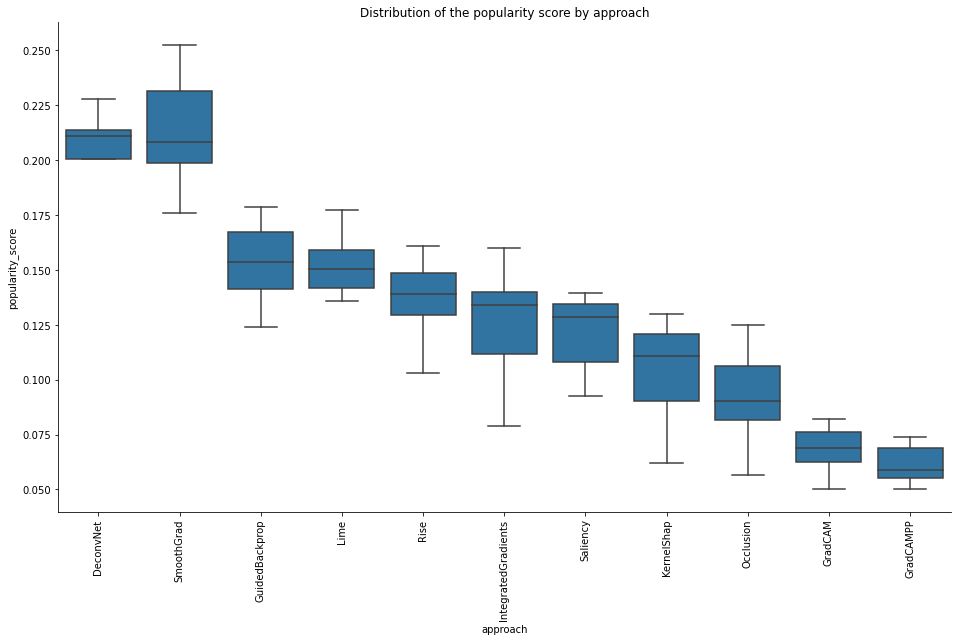

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils.general import save_figure

fig = plt.figure(figsize=(16,9))
plot_data = selected_clusters[~selected_clusters['clustering_mode'].isna()]
plot_data = plot_data.set_index('approach').loc[plot_data.groupby('approach')['popularity_score'].median().sort_values(ascending=False).index]
ax = sns.boxplot(x=plot_data.index, y='popularity_score', data=plot_data, color=sns.color_palette()[0], showfliers=False)
ax.set_title('Distribution of the popularity score by approach')
plt.xticks(rotation=90)
sns.despine()
save_figure(fig, '/Users/lodovicoazzini/Desktop/pularity')

In [23]:
from matplotlib import pyplot as plt
import tensorflow as tf
from utils.cluster.visualize import visualize_cluster_images
from utils.general import get_balanced_samples, save_figure
import sys
from utils.cluster.postprocessing import get_misses_count, get_labels_purity

# Iterate through the approaches
approaches = selected_clusters.index.values
for idx_approach, approach in enumerate(approaches):
    sys.stdout.write('\r')
    sys.stdout.write(
        f'{idx_approach + 1}/{len(approaches)} - {approach}\n'
    )
    # Get the clusters for the selected approach
    clusters, contributions = selected_clusters.loc[approach][['clusters', 'contributions']]
    clusters = np.array(clusters, dtype=list)
    # Create the numpy array for the contributions or set it to None if no contributions
    contributions = None if type(contributions) == float else np.array(contributions, dtype=float)
    # Find the count of misclassified entries in each cluster
    counts_misses = np.vectorize(lambda cl: get_misses_count(cl, predictions=predictions))(clusters)
    # Find the purity and impurity of each cluster
    purities = np.vectorize(lambda cl: get_labels_purity(cl, predictions=predictions))(clusters)
    # Weight the purity and impurity based on the count of misclassified elements in log scale
    counts_misses_log = np.vectorize(lambda val: 0 if val == 0 else np.log(val))(counts_misses)
    # Get the pure and impure sample
    pure_sample, impure_sample = get_balanced_samples(clusters, sample_size=5, balanced_by=purities, weights=counts_misses_log)
    all_samples = np.concatenate((pure_sample, impure_sample))

    for idx, cluster in enumerate(all_samples):
        fig, ax = visualize_cluster_images(
            np.array(cluster),
            images=tf.image.rgb_to_grayscale(test_data[mask_label]).numpy(),
            overlays=contributions,
            predictions=predictions[mask_label],
        )
        plt.close(fig)

        save_figure(fig, f'/Users/lodovicoazzini/Desktop/human_evaluation/{approach}_{idx}_{len(cluster)}')

        sys.stdout.write('\r')
        progress = int((idx + 1) / len(all_samples) * 100)
        progress_bar_len = 20
        progress_bar_filled = int(progress / 100 * progress_bar_len)
        sys.stdout.write(
            f'[{progress_bar_filled * "="}{(progress_bar_len - progress_bar_filled) * " "}]\t{progress}%')
        sys.stdout.flush()
    print()

1/17 - moves+bitmaps(10x10)_original
[====================]	100%
2/17 - moves+orientation(10x10)_original
[====================]	100%
3/17 - orientation+bitmaps(10x10)_original
[====================]	100%
4/17 - moves+bitmaps(25x25)_original
[====================]	100%
5/17 - moves+orientation(25x25)_original
[====================]	100%
6/17 - orientation+bitmaps(25x25)_original
[====================]	100%
7/17 - DeconvNet
[====================]	100%
8/17 - Occlusion
[====================]	100%
9/17 - Saliency
[====================]	100%
10/17 - GuidedBackprop
[====================]	100%
11/17 - Lime
[====================]	100%
12/17 - GradCAM
[====================]	100%
13/17 - IntegratedGradients
[====================]	100%
14/17 - KernelShap
[====================]	100%
15/17 - SmoothGrad
[====================]	100%
16/17 - GradCAMPP
[====================]	100%
17/17 - Rise
[====================]	100%


In [40]:


base_dir = '/Users/lodovicoazzini/Desktop/human_evaluation'
# Create the csv file with the paths for the images to use
images_paths = sorted(image_path for image_path in os.listdir(base_dir) if image_path.endswith('.png'))
with open('/Users/lodovicoazzini/Desktop/understandability.csv', mode='w') as file:
    for path in images_paths:
        file.write(f'human_evaluation/{path}')
        file.write('\n')
    # writer.writerow(images_paths)